In [14]:
seed = 0

import os
import sys

os.chdir('..')
utils_path = os.path.abspath("./utilities/")
sys.path.append(utils_path)

from load_data import load_fullECAI
from evaluation import *
from evaluation import _my_scorer

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, OneHotEncoder, Normalizer
from sklearn.metrics import euclidean_distances
import joblib
from joblib import Parallel, delayed
import shap

from igraph import Graph
import igraph as ig

In [17]:
def mean_degree(g):
    degree = g.degree_distribution()
    
    return degree.mean

def frac_nodes_large_component(g):
    # Cambiar por comunidades
    return


def mean_dist_node_pairs(g):
    return


def exp_power_law_degrees(g):
    degrees = g.degree(g.vs)
    fitted = ig.statistics.power_law_fit(degrees)
    
    return fitted.alpha, fitted.xmin, fitted.p

def exp_power_law_strengths(g):
    strengths = g.strength(g.vs, weights=1/(1+np.array(g.es['weight'])))
    fitted = ig.statistics.power_law_fit(strenghts)
    
    return fitted.alpha, fitted.xmin, fitted.p


def cluster_coeff(g):
    return g.transitivity_undirected()


def random_cluster_coeff(g):
    n = g.vcount()
    degrees = g.degree(g.vs, loops=False)
    unique_degrees, degree_freqs = np.unique(degrees, return_counts=True)
    prop_degrees = degree_freqs/n
    moment_1 = np.dot(unique_degrees, prop_degrees)
    moment_2 = np.dot(unique_degrees**2, prop_degrees)
    
    return (1/n) * ((moment_2 - moment_1)**2) / (moment_1**3)



def cluster_coeff_alt(g):
    return


def modularity(g):
    # Checar si este es con distancias o fuerzas
    mod = g.modularity(y_test.to_list(), weights=1/(1+np.array(g.es['weight'])))
    return mod

def summary(result, model_name):
    summary_stats = {}
    summary_stats['modelo'] = model_name
    summary_stats['corte'] = result[0]
    summary_stats['global_efficiency'] = result[1]
    summary_stats['aristas'] = result[2]
    summary_stats['mean_degree'] = mean_degree(result[3])
    alpha, xmin, p = exp_power_law_degrees(result[3])
    summary_stats['pow_degree_alpha'] = alpha
    summary_stats['pow_degree_xmin'] = xmin
    summary_stats['pow_degree_p'] = p
    alpha, xmin, p = exp_power_law_degrees(result[3])
    summary_stats['pow_str_alpha'] = alpha
    summary_stats['pow_str_xmin'] = xmin
    summary_stats['pow_str_p'] = p
    summary_stats['cluster_coeff'] = cluster_coeff(result[3])
    summary_stats['modularity'] = modularity(result[3])
    
    return summary_stats

def stats_by_model(model):
    """
    
    Parameters
    ----------
    model: str
        Path of model.pkl
    """
    model_folder = '/'.join(model.split('/')[:-1])
    model_name = model.split('/')[-1].split('.')[0]
    results = joblib.load('{}/{}_reduced_graphs_efficiency.pkl'.format(model_folder, model_name))
    
    ## Stats per cutoff
    stats_tmp = Parallel(n_jobs=5)(delayed(summary)(r, model_name) for r in results)
    
    return stats_tmp

def plot_codo_eff_global(results, ax=None):
    if ax is None:
        ax = plt.gca()
        
    g_efficiencies = pd.Series(list(zip(*results))[1])
    g_efficiencies.plot(ax=ax)
    ax.set_title('{}: Eficiencia Global para distintos cortes'.format(model_name))

In [3]:
dataset = load_fullECAI()
# Prep data
X = dataset.drop('status', axis=1)
y = dataset.loc[:, 'status']

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=seed, stratify=y)

In [4]:
models_paths = ['./results/XGBoost/GridSearchCV_22-03-22_03-27-03/models/best/best_xgb.pkl', 
                './results/Basic/models/RandomForestClassifier.pkl', 
                './results/Basic/models/LogisticRegression.pkl',
                './results/Basic/models/LinearDiscriminantAnalysis.pkl',
                './results/Basic/models/XGBClassifier.pkl']

In [5]:
model = models_paths[0]
model_folder = '/'.join(model.split('/')[:-1])
model_name = model.split('/')[-1].split('.')[0]
results = joblib.load('{}/{}_reduced_graphs_efficiency.pkl'.format(model_folder, model_name))

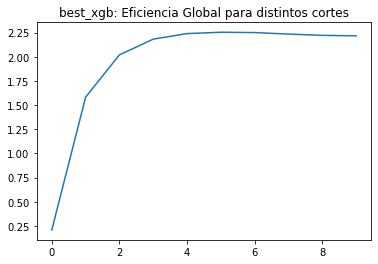

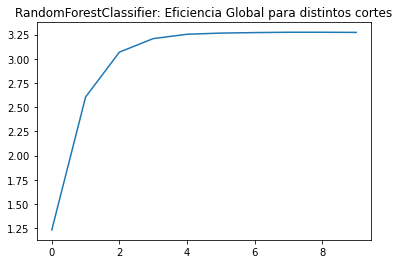

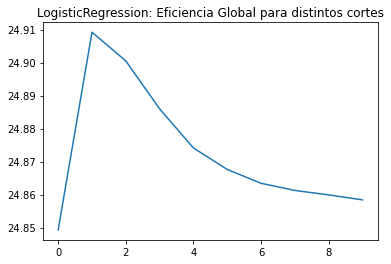

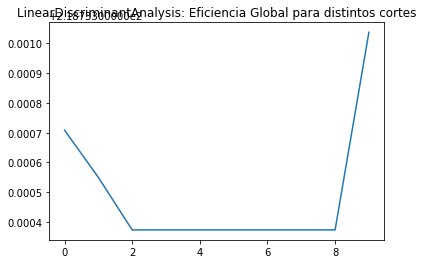

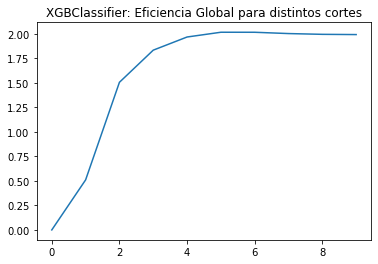

In [20]:
for model in models_paths:
    model_folder = '/'.join(model.split('/')[:-1])
    model_name = model.split('/')[-1].split('.')[0]
    results = joblib.load('{}/{}_reduced_graphs_efficiency.pkl'.format(model_folder, model_name))

    plot_codo_eff_global(results, ax=None)
    fig_name = '{}_codo.png'.format(model_name)
    fig_path = './results/figures/graphs/{}'.format(fig_name)
    plt.savefig(fig_path, bbox_inches='tight', dpi=300, transparent=True)
    plt.show()

In [59]:
stats_total = []
for model in models_paths:
    stats_tmp = stats_by_model(model)
    stats_total = stats_total + stats_tmp
stats_df = pd.DataFrame(stats_total)
stats_df['per_max_eff'] = stats_df.global_efficiency / stats_df.groupby('modelo').global_efficiency.transform(np.max)

In [93]:
# Optimal
stats_df[stats_df['per_max_eff'] > .75].groupby('modelo').first()

,corte,global_efficiency,aristas,mean_degree,pow_degree_alpha,pow_degree_xmin,pow_degree_p,pow_str_alpha,pow_str_xmin,pow_str_p,cluster_coeff,modularity,% Max Efficiency,per_max_eff
modelo,,,,,,,,,,,,,,
LinearDiscriminantAnalysis,0.1,218.733709,4495830,2988.255234,3433.082018,2998.0,0.062053,3433.082018,2998.0,0.062053,0.999675,-0.000026,0.999998,0.999998
LogisticRegression,0.1,24.849282,2303025,1530.757727,391.758003,2251.0,0.986096,391.758003,2251.0,0.986096,0.932081,0.001070,0.997595,0.997595
RandomForestClassifier,0.2,2.605120,743054,493.887670,27.957580,1203.0,0.156089,27.957580,1203.0,0.156089,0.715629,0.000840,0.795695,0.795695
XGBClassifier,0.4,1.832364,1148265,763.220339,35.319029,1630.0,0.989965,35.319029,1630.0,0.989965,0.652561,0.007619,0.909415,0.909415
best_xgb,0.3,2.019724,729971,485.191758,11.293838,977.0,0.213521,11.293838,977.0,0.213521,0.689643,0.018913,0.896160,0.896160


In [94]:
stats_df

,modelo,corte,global_efficiency,aristas,mean_degree,pow_degree_alpha,pow_degree_xmin,pow_degree_p,pow_str_alpha,pow_str_xmin,pow_str_p,cluster_coeff,modularity,% Max Efficiency,per_max_eff
0,best_xgb,0.1,0.208811,8422,5.597873,2.132089,8.0,8.891367e-02,2.132089,8.0,8.891367e-02,0.639503,0.042384,0.092650,0.092650
1,best_xgb,0.2,1.582012,170298,113.192423,7.769554,353.0,1.110526e-01,7.769554,353.0,1.110526e-01,0.606946,0.024734,0.701945,0.701945
2,best_xgb,0.3,2.019724,729971,485.191758,11.293838,977.0,2.135207e-01,11.293838,977.0,2.135207e-01,0.689643,0.018913,0.896160,0.896160
3,best_xgb,0.4,2.182409,1624212,1079.569292,96.796118,1928.0,9.922593e-01,96.796118,1928.0,9.922593e-01,0.789802,0.015073,0.968344,0.968344
4,best_xgb,0.5,2.239732,2498458,1660.656697,16.257166,2124.0,3.040092e-01,16.257166,2124.0,3.040092e-01,0.858718,0.012935,0.993779,0.993779
5,best_xgb,0.6,2.253753,3336720,2217.826520,10.215240,2289.0,1.853580e-11,10.215240,2289.0,1.853580e-11,0.865016,0.010872,1.000000,1.000000
6,best_xgb,0.7,2.250345,4079939,2711.823862,2018.838683,3006.0,8.560743e-01,2018.838683,3006.0,8.560743e-01,0.936249,0.007829,0.998488,0.998488
7,best_xgb,0.8,2.234777,4403302,2926.754403,12.060715,2706.0,0.000000e+00,12.060715,2706.0,0.000000e+00,0.979242,0.004917,0.991580,0.991580
8,best_xgb,0.9,2.221705,4512639,2999.427717,2111.528771,3007.0,0.000000e+00,2111.528771,3007.0,0.000000e+00,0.997340,0.003066,0.985780,0.985780
9,best_xgb,1.0,2.216418,4525536,3008.000000,9659.355375,3008.0,1.000000e+00,9659.355375,3008.0,1.000000e+00,1.000000,0.002851,0.983434,0.983434
